In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict # Remove load_metric from datasets import
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)
import numpy as np # Import numpy

In [ ]:
model_name = "VietAI/vit5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/904M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/904M [00:00<?, ?B/s]

In [ ]:
# 2. Load dataset gốc (1 file CSV duy nhất)
# ==============================
df = pd.read_csv("dataset_all NLP.csv")   # file gốc bạn đưa vào

# Chia 80% train, 20% validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert sang HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
dataset = DatasetDict({"train": train_dataset, "validation": val_dataset})


In [ ]:
# 4. Data collator
# ==============================
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
# 3. Tiền xử lý dữ liệu
# ==============================
max_input_length = 512
max_target_length = 128

def preprocess_function(examples):
    inputs = examples["article"]
    targets = examples["summary"]
    model_inputs = tokenizer(
        inputs, max_length=max_input_length, truncation=True, padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets, max_length=max_target_length, truncation=True, padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3041 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/761 [00:00<?, ? examples/s]

In [ ]:
# 5. Training arguments
# ==============================
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,   # chỉnh nhỏ nếu GPU yếu
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=12,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    logging_dir="./logs",
    logging_steps=50,
    # Add the following arguments to enable ROUGE calculation during evaluation
    metric_for_best_model="rougeL",
    greater_is_better=True,
    load_best_model_at_end=True,
)

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f2d8aa7726be5cb46fa31e0f54d6e81a3519d48dd47165a9b1280056538a5ae0
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
# 6. Trainer
# ==============================

# Define compute_metrics function for ROUGE calculation
import evaluate

metric = evaluate.load("rouge")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_predictions = ["\n".join(pred.strip().split(".")) for pred in decoded_predictions]
    decoded_labels = ["\n".join(label.strip().split(".")) for label in decoded_labels]

    result = metric.compute(predictions=decoded_predictions, references=decoded_labels, use_stemmer=True)
    # Extract ROUGE f1 scores, handling potential float values
    formatted_result = {}
    for key, value in result.items():
        if hasattr(value, 'mid') and hasattr(value.mid, 'fmeasure'):
            formatted_result[key] = value.mid.fmeasure * 100
        else:
            # If the value is a float, assume it's the fmeasure and use it directly
            formatted_result[key] = value * 100 if isinstance(value, (int, float)) else value

    # Add mean generated lengths
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    formatted_result["gen_len"] = np.mean(prediction_lens)

    return formatted_result

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics # Add compute_metrics to trainer
)

/tmp/ipython-input-3615932573.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:

# 7. Train
# ==============================
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dtc225210147 (dtc225210147-samsung-electronics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,0.269500,0.205162,62.483138,53.880813,58.582276,58.972573,19.971091
2,0.223100,0.206786,62.285471,53.394969,58.148665,58.556943,19.996058
3,0.139600,0.212502,62.854988,53.874711,58.625548,59.088786,19.988173
4,0.149500,0.224371,62.413364,53.772641,58.365180,58.794518,19.972405
5,0.108000,0.240353,62.636960,53.893421,58.428254,58.845480,19.967148
6,0.088300,0.255831,62.903633,54.484148,58.909346,59.318126,19.968463
7,0.068500,0.275350,62.780473,54.351983,58.809412,59.187495,19.972405
8,0.055000,0.283503,62.644912,54.184697,58.752588,59.152808,19.972405


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,0.269500,0.205162,62.483138,53.880813,58.582276,58.972573,19.971091
2,0.223100,0.206786,62.285471,53.394969,58.148665,58.556943,19.996058
3,0.139600,0.212502,62.854988,53.874711,58.625548,59.088786,19.988173
4,0.149500,0.224371,62.413364,53.772641,58.365180,58.794518,19.972405
5,0.108000,0.240353,62.636960,53.893421,58.428254,58.845480,19.967148
6,0.088300,0.255831,62.903633,54.484148,58.909346,59.318126,19.968463
7,0.068500,0.275350,62.780473,54.351983,58.809412,59.187495,19.972405
8,0.055000,0.283503,62.644912,54.184697,58.752588,59.152808,19.972405
9,0.044900,0.312625,62.691673,53.962686,58.619451,59.037020,19.968463
10,0.044300,0.319878,62.728594,54.054831,58.732309,59.162385,19.968463


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=9132, training_loss=0.14018370059045113, metrics={'train_runtime': 5538.9637, 'train_samples_per_second': 6.588, 'train_steps_per_second': 1.649, 'total_flos': 2.222209134231552e+16, 'train_loss': 0.14018370059045113, 'epoch': 12.0})

In [ ]:
output_dir = "/content/drive/MyDrive/NLP/vit5-finetuned"

# lưu model và tokenizer vào Google Drive
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)


('/content/drive/MyDrive/NLP/vit5-finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/NLP/vit5-finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/NLP/vit5-finetuned/spiece.model',
 '/content/drive/MyDrive/NLP/vit5-finetuned/added_tokens.json',
 '/content/drive/MyDrive/NLP/vit5-finetuned/tokenizer.json')

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import requests
from bs4 import BeautifulSoup

device = "cuda" if torch.cuda.is_available() else "cpu"

def get_text_from_url(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    paragraphs = soup.find_all("p")
    text = " ".join([p.get_text() for p in paragraphs])
    return text

def summarize_text(url):
    text = get_text_from_url(url)

    inputs = tokenizer(
        text,
        return_tensors="pt",
        max_length=1024,
        truncation=True
    ).to(device)   # ⚡ Đưa input lên cùng device với model

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=200,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

output_dir = "/content/drive/MyDrive/NLP/vit5-finetuned"

model = AutoModelForSeq2SeqLM.from_pretrained(output_dir).to(device)
tokenizer = AutoTokenizer.from_pretrained(output_dir)

In [ ]:
import gradio as gr

def summarize_from_ui(input_text):
    return summarize_text(input_text)

demo = gr.Interface(
    fn=summarize_from_ui,
    inputs="text",
    outputs="text",
    title="📰 Tóm tắt bài báo với ViT5",
    description="Dán link hoặc nhập văn bản để nhận bản tóm tắt"
)

demo.launch(share=True)  # share=True tạo link public tạm


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9d03123ff462955dfb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Đánh giá mô hình trên tập validation
results = trainer.evaluate()

print("===== KẾT QUẢ ĐÁNH GIÁ ROUGE =====")
for key, value in results.items():
    if key.startswith("eval_rouge"):
        print(f"{key}: {value:.2f}")


===== KẾT QUẢ ĐÁNH GIÁ ROUGE =====
eval_rouge1: 62.90
eval_rouge2: 54.48
eval_rougeL: 58.91
eval_rougeLsum: 59.32


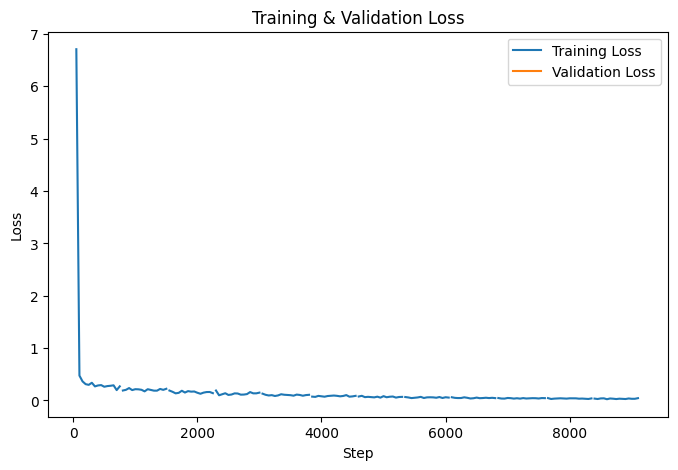

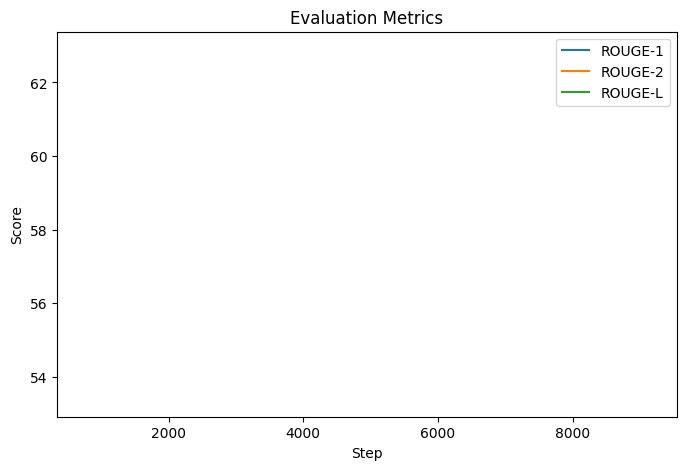

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử bạn có trainer đã train xong
log_history = trainer.state.log_history

# Chuyển thành DataFrame cho dễ xử lý
df = pd.DataFrame(log_history)

# Vẽ loss
plt.figure(figsize=(8, 5))
plt.plot(df["step"], df["loss"], label="Training Loss")
if "eval_loss" in df.columns:
    plt.plot(df["step"], df["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Nếu có metric đánh giá (ví dụ ROUGE)
if "eval_rouge1" in df.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(df["step"], df["eval_rouge1"], label="ROUGE-1")
    plt.plot(df["step"], df["eval_rouge2"], label="ROUGE-2")
    plt.plot(df["step"], df["eval_rougeL"], label="ROUGE-L")
    plt.xlabel("Step")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics")
    plt.legend()
    plt.show()


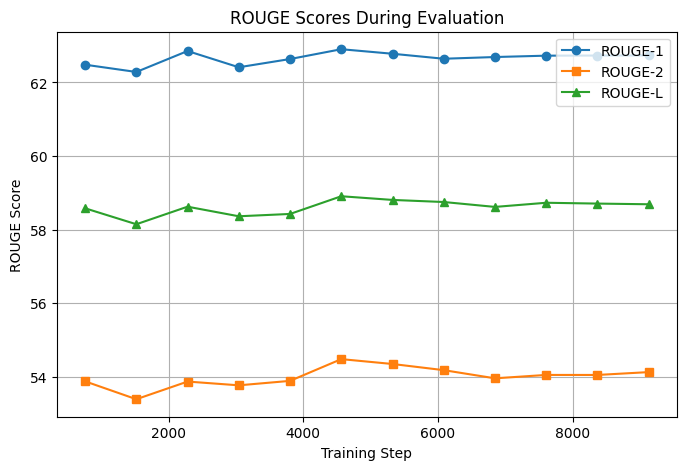

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy log sau khi train
log_history = trainer.state.log_history

# Đưa về DataFrame
df = pd.DataFrame(log_history)

# Chỉ lấy những hàng có eval_rouge
df_rouge = df[[col for col in df.columns if col.startswith("eval_") or col == "step"]].dropna()

# Vẽ ROUGE-1, ROUGE-2, ROUGE-L
plt.figure(figsize=(8,5))
plt.plot(df_rouge["step"], df_rouge["eval_rouge1"], marker="o", label="ROUGE-1")
plt.plot(df_rouge["step"], df_rouge["eval_rouge2"], marker="s", label="ROUGE-2")
plt.plot(df_rouge["step"], df_rouge["eval_rougeL"], marker="^", label="ROUGE-L")

plt.xlabel("Training Step")
plt.ylabel("ROUGE Score")
plt.title("ROUGE Scores During Evaluation")
plt.legend()
plt.grid(True)
plt.show()
